In [1]:
import os
import cv2
import matplotlib.pyplot as plt
from random import randint
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [2]:
base_dir='E:\chest_xray'
train_dir=os.path.join(base_dir,'train')
test_dir=os.path.join(base_dir,'test')
sample_image_pneumonia=os.listdir(os.path.join(train_dir,'PNEUMONIA'))
sample_image_healthy=os.listdir(os.path.join(train_dir,'NORMAL'))

In [3]:
class callbacka(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs={}):
        if(logs.get('val_accuracy')>=0.91):
            print("\nLoss is low stopping trainng")
            self.model.stop_training=True

In [4]:
mcallbacks=callbacka()

In [5]:
img_size=110

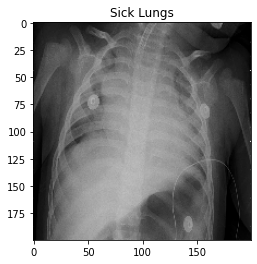

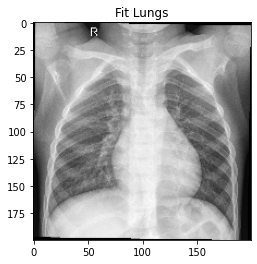

In [6]:
sample_image_pnue=sample_image_pneumonia[randint(0,(len(sample_image_pneumonia)-1))]
sample_image_normal=sample_image_healthy[randint(0,(len(sample_image_healthy)-1))]

img_to_array_sick=cv2.imread(os.path.join(os.path.join(train_dir,'PNEUMONIA'),sample_image_pnue))
img_to_array_fit=cv2.imread(os.path.join(os.path.join(train_dir,'NORMAL'),sample_image_normal))

plt.imshow(cv2.resize(img_to_array_sick,(200,200)))
plt.title("Sick Lungs")
plt.show()

plt.imshow(cv2.resize(img_to_array_fit,(200,200)))
plt.title("Fit Lungs")
plt.show()

In [8]:
def get_train_generator(image_dir):
    
    image_generator = ImageDataGenerator(
        rescale=1/255,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        zoom_range = 0.3,
        horizontal_flip = True,
        )
    
    
        
    generator = image_generator.flow_from_directory(train_dir,batch_size=5,class_mode='binary',target_size=(img_size,img_size),shuffle=True)
    return generator

In [9]:
def get_test_generator(train_dir,test_dir):
    
    #stats_train_generator= ImageDataGenerator().flow_from_directory(directory=train_dir,batch_size=200,shuffle=True,target_size=(img_size,img_size))
    #batch = stats_train_generator.next()
    #data_sample=batch[0]
    
    test_datagen = ImageDataGenerator(rescale=1./255.0)
    #test_datagen.fit(data_sample)
    valid_generator=test_datagen.flow_from_directory(test_dir,batch_size=10,class_mode='binary',target_size=(img_size,img_size),shuffle=False)
    return valid_generator      

In [10]:
train_generator = get_train_generator(train_dir)
valid_generator = get_test_generator(train_dir,test_dir)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


1.0


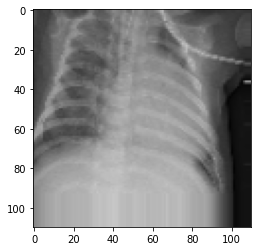

In [11]:
x, y = train_generator.__getitem__(0)
print(y[0])
plt.imshow(x[0])

0.48947245
0.19272643


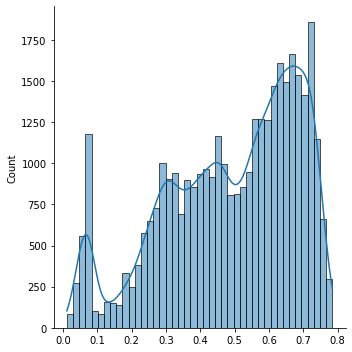

In [12]:
import seaborn as sns
sns.displot(x[0].ravel(),kde=True)
print(np.mean(x[0]))
print(np.std(x[0]))

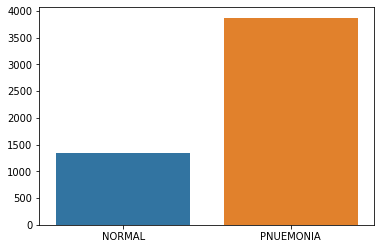

In [13]:
labels=['NORMAL','PNUEMONIA']
frequency=[list(train_generator.labels).count(0),list(train_generator.labels).count(1)]
sns.barplot(x=labels,y=frequency)
plt.show()

In [14]:
type(train_generator.labels)

numpy.ndarray

In [15]:
from sklearn.utils import class_weight

In [16]:
y_unique=np.unique(train_generator.labels)
y_train=train_generator.labels
class_weights=class_weight.compute_class_weight('balanced',y_unique,y_train)
class_weights=dict(enumerate(class_weights))

c:\users\adris\miniconda3\envs\chest_net\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 1 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [17]:
print(class_weights)

{0: 1.9448173005219984, 1: 0.6730322580645162}


In [18]:
def build_model():
    pre_trained_model=DenseNet121(input_shape=(img_size,img_size,3),include_top=False,weights='imagenet')

    for layer in pre_trained_model.layers:
        layer.trainable = False
    last_layer=pre_trained_model.get_layer('conv3_block12_concat')
    last_output=last_layer.output
    x=layers.Flatten()(last_output)
    x=layers.Dense(512,activation='relu')(x)
    x=layers.Dropout(0.2)(x)
    predictions =layers.Dense(1,activation='sigmoid')(x)
    model = Model(inputs=pre_trained_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
    return model

In [19]:
model=build_model()

In [20]:
history=model.fit(train_generator,validation_data=valid_generator,class_weight=class_weights,steps_per_epoch=134,epochs=20,validation_steps=60,verbose=2,callbacks=[mcallbacks])

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/20
134/134 - 48s - loss: 2.2259 - accuracy: 0.6672 - val_loss: 0.3833 - val_accuracy: 0.8233
Epoch 2/20
134/134 - 47s - loss: 0.5522 - accuracy: 0.7716 - val_loss: 0.4670 - val_accuracy: 0.7850
Epoch 3/20
134/134 - 46s - loss: 0.3762 - accuracy: 0.8194 - val_loss: 0.3298 - val_accuracy: 0.8700
Epoch 4/20
134/134 - 45s - loss: 0.3389 - accuracy: 0.8358 - val_loss: 0.3764 - val_accuracy: 0.8250
Epoch 5/20
134/134 - 45s - loss: 0.2640 - accuracy: 0.8970 - val_loss: 0.3989 - val_accuracy: 0.8167
Epoch 6/20
134/134 - 45s - loss: 0.3429 - accuracy: 0.8318 - val_loss: 0.3516 - val_accuracy: 0.8667
Epoch 7/20
134/134 - 45s - loss: 0.2796 - accuracy: 0.8806 - val_loss: 0.7441 - val_accuracy: 0.6783
Epoch 8/20
134/134 - 45s - loss: 0.2906 - accuracy: 0.8619 - val_loss: 0.5034 - val_accuracy: 0.7967
Epoch 9/20
134/134 - 45s - loss: 0.3150 - accuracy: 0.

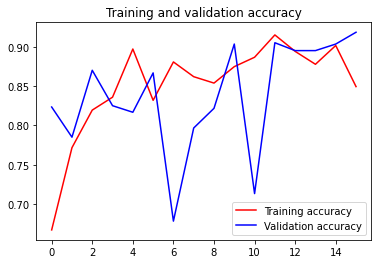

<Figure size 432x288 with 0 Axes>

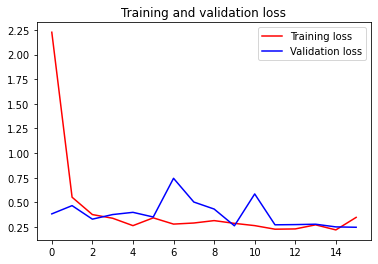

<Figure size 432x288 with 0 Axes>

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()
plt.plot(epochs,loss, 'r', label="Training loss")
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [22]:
predicted_vals_test = model.predict(valid_generator, steps = len(valid_generator))

In [23]:
from sklearn.metrics import roc_auc_score, roc_curve

In [24]:
from sklearn.metrics import precision_recall_curve

In [25]:
fpr,tpr,threshold_roc=roc_curve(valid_generator.labels,predicted_vals_test)

In [26]:
precision,recall,threshold_pr=precision_recall_curve(valid_generator.labels,predicted_vals_test)

In [27]:
import pandas as pd

In [28]:
from sklearn.metrics import accuracy_score
accuracy_ls=[]
for thresh in threshold_roc:
    y_pred=np.where(predicted_vals_test>thresh,1,0)
    accuracy_ls.append(accuracy_score(valid_generator.labels,y_pred,))
accuracy_scores=pd.concat([pd.Series(threshold_roc),pd.Series(fpr),pd.Series(tpr),pd.Series(accuracy_ls)],axis=1)
accuracy_scores.columns=['THRESHOLD','FALSE POSITIVE RATE','TRUE POSITIVE RATE','ACCURACY_SCORE']
accuracy_scores.sort_values(by='ACCURACY_SCORE',ascending=False,inplace=True)

In [29]:
accuracy_scores.head()

,THRESHOLD,FALSE POSITIVE RATE,TRUE POSITIVE RATE,ACCURACY_SCORE
42,0.515081,0.072650,0.912821,0.916667
45,0.451279,0.102564,0.917949,0.913462
41,0.527579,0.072650,0.902564,0.913462
44,0.454510,0.094017,0.917949,0.911859
43,0.468030,0.094017,0.912821,0.911859


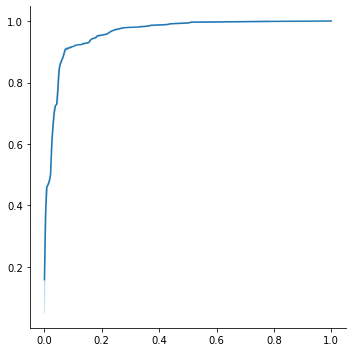

In [30]:
sns.relplot(x=fpr,y=tpr,kind='line')
plt.show()

In [36]:
accuracy_ls_pr=[]
for thresh in threshold_pr:
    y_pred=np.where(predicted_vals_test>thresh,1,0)
    accuracy_ls_pr.append(accuracy_score(valid_generator.labels,y_pred,))
accuracy_scores_pr=pd.concat([pd.Series(threshold_pr),pd.Series(precision),pd.Series(recall),pd.Series(accuracy_ls_pr)],axis=1)
accuracy_scores_pr.columns=['THRESHOLD','PRECISION','RECALL','ACCURACY_SCORE']
accuracy_scores_pr.sort_values(by='ACCURACY_SCORE',ascending=False,inplace=True)

In [37]:
accuracy_scores_pr.head()

,THRESHOLD,PRECISION,RECALL,ACCURACY_SCORE
197,0.511214,0.951872,0.912821,0.918269
198,0.515081,0.954424,0.912821,0.916667
196,0.477899,0.949333,0.912821,0.916667
199,0.516048,0.954301,0.910256,0.915064
195,0.471425,0.946809,0.912821,0.915064


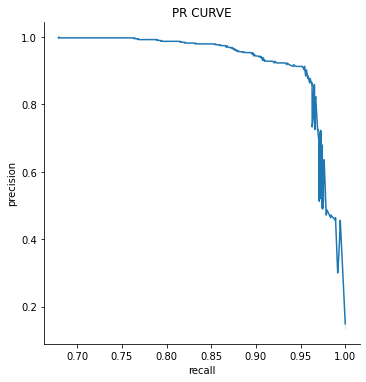

In [33]:
sns.relplot(x=precision,y=recall,kind='line')
plt.title('PR CURVE')
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()

In [34]:
model.save('CHEST_NET_121_CNN.model')

INFO:tensorflow:Assets written to: CHEST_NET_121_CNN.model\assets


In [ ]:
accuracy_scores.to_csv('AUC_ROC_SCORES.csv')

In [35]:
model.save('CHEST_NET_121_CNN.h5')